# Traget: using pyton and mumpy implement a neural network framework
Node:
+ forwrd: *function*, how to calculate the inputs
+ backwards: *function*, how to get the gradients when backpropogation
+ gradients: *Mapper*, the gradient map this node of its inputs node
+ inputs: *List*
+ outputs: *list*


## 面向对象的方式来组织

## 构建基类

In [465]:
class Node:
    """
    each node in neural network will have these arrtributes and methods
    """
    def __init__(self,inputs=[]):
        """
        if the node is the operator of 'ax+b', the inputs will be x node, and the outputs of this is its successors.
        and the value is 'ax + b'
        """
        self.inputs = inputs # input list <- C, Java <- 匈牙利命名法 -> Python 特别不建议 ， python定义时无类型
        #self.outputs = outputs # output list 
        self.value = None
        self.outputs = []
        self.gradients = {}
        
        for node in self.inputs: # variable without type , plural 
            node.outputs.append(self)
    
    def forward(self):
        """
        forward propogation
        compute the output value based on input nodes and store the value into "self.value"
        """
        raise NotImplemented  # imaginary class
    
    def backward(self):
        
        """
        Back propogation
        compute the gradient of each input node and store the value into "self.gradients"
        """
        return NotImplemented  # imaginary class
    

## 构建子类
+ Input node
+ Linear Node
+ Sigmoid Node


In [466]:
class Input(Node):
    def __init__(self, name=''):
        Node.__init__(self, inputs=[])
        self.name= name
    
    def forward(self, value=None):
        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
    
    def __repr__(self):
        return 'Input Node: {}'.format(self.name)

In [467]:
import numpy as np

In [468]:
X = np.array([1,2,3])

In [469]:
w = np.array([[1,2],[2,4],[3,5]])

In [470]:
np.dot(X,w)

array([14, 25])

In [519]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self,inputs = [nodes, weights, bias])
        
    def forward(self):
        """
        compute the wx+b using numpy
        """
        self.value = np.dot(self.x_node.value, self.w_node.value)+self.b_node.value
        
    def backward(self):
        for node in self.outputs:
            grad_cost = node.gradients[self]
            
            self.gradients[self.w_node]= np.dot(self.x_node.value.T,grad_cost) # partial(loss)/partial(w) = partial(loss)/partial(self)*x
            self.gradients[self.b_node]= np.sum(grad_cost * 1, axis = 0, keepdims = False) # partial(loss)/partial(b) = partial(loss)/partial(self)*1
            self.gradients[self.x_node]= np.dot(grad_cost, self.w_node.value.T)


In [520]:
# class Linear(Node):
#     def __init__(self, nodes, weights, bias):
#         self.w_node = weights
#         self.x_node = nodes
#         self.b_node = bias
#         Node.__init__(self, inputs=[nodes, weights, bias])
    
#     def forward(self): 
#         """compute the wx + b using numpy"""
#         self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value
        
    
#     def backward(self):
        
#         for node in self.outputs:
#             #gradient_of_loss_of_this_output_node = node.gradient[self]
#             grad_cost = node.gradients[self]
            
#             self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost)
#             self.gradients[self.b_node] = np.sum(grad_cost * 1, axis=0, keepdims=False)
#             self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)

In [521]:
class Sigmoid(Node):
    def __init__(self,node):
        Node.__init__(self,[node])
        self.x_node = node
        
    def _sigmoid(self,x):
        return 1./(1+np.exp(-1 * x ))
    
    def forward(self):
        self.value  = self._sigmoid(self.x_node.value) 
        
    def backward(self):
        y = self.value
        
        self.partial = y * (1-y)
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            
            self.gradients[self.x_node] = grad_cost * self.partial

In [522]:
W1 = np.array([[1,1],[1,2],[1,3]])
W2 = np.array([[0,1],[3,2],[2,3]])


In [523]:
W1

array([[1, 1],
       [1, 2],
       [1, 3]])

In [524]:
W1.reshape(-1,1)

array([[1],
       [1],
       [1],
       [2],
       [1],
       [3]])

In [525]:
W1.reshape(-1)

array([1, 1, 1, 2, 1, 3])

In [526]:
W1.shape[0]

3

In [527]:
W1.reshape(-1,1).shape[0]

6

In [528]:
(W1.reshape(-1,1)-W2.reshape(-1,1))**2

array([[1],
       [0],
       [4],
       [0],
       [1],
       [0]], dtype=int32)

In [529]:
class MSE(Node):
    def __init__(self,y_true, y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self, inputs = [y_true, y_hat])
         
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1,1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1,1)
        self.diff = y_true_flatten-y_hat_flatten
        self.value = np.mean(self.diff ** 2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0] # shape [0] 第一个维度大小；        
        self.gradients[self.y_true_node] =  (2 / n) * self.diff
        self.gradients[self.y_hat_node] = (-2 / n) * self.diff
        
    def __str__(self):
        print('MSE with ****')
  

In [530]:
def training_one_batch(topological_sorted_graph):
    # graph 经过拓扑排序之后的一个list
    for node in topological_sorted_graph:
        node.forward()
        
    for node in topological_sorted_graph[::-1]:
        node.backward()
        

In [531]:
def topological_sort(data_with_value):
    feed_dict = data_with_value
    input_nodes = [n for n in feed_dict.keys()]
    
    G = {}
    nodes = [ n for n in input_nodes]
    while len(nodes)>0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out' : set()}
        for m in n.outputs:
            if m not in G:
                G[m] = { 'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    L = []
    S  = set(input_nodes)
    while len(S)>0:
        n = S.pop()
        
        if isinstance(n,Input):
            n.value = feed_dict[n]
            ## if n is Input node, set a value as feed_dic[n]
            ## else, n's value is calculated as its inbounds
            
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edge add to S
            if len(G[m]['in'])== 0:
                S.add(m)
    return L
        

In [532]:
def sgd_update(trainable_nodes, learning_rate = 1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]  # partial(loss)/partial(t)

In [533]:
from sklearn.datasets import load_boston

In [534]:
data  = load_boston()

In [535]:
X_ = data['data']

In [536]:
X_

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [537]:
y_ = data['target']

In [538]:
X_ = (X_-np.mean(X_, axis=0))/np.std(X_,axis=0)

In [539]:
n_features = X_.shape[1]

In [540]:
n_features

13

In [541]:
n_hidden = 10

In [542]:
W1_, b1_= np.random.randn(n_features, n_hidden), np.zeros(n_hidden)

In [543]:
W2_, b2_= np.random.randn(n_hidden, 1), np.zeros(1)

In [544]:
#W3_,b3_ = np.random.randn(n_hidden2,1), np.zeros(1)

## Build a graph conneciton
### Build nodes in this graph

In [545]:
X, y = Input(name = 'X'), Input(name = 'y')  # Tensorflor -> placeholder
W1, b1 = Input(name = 'W1'), Input(name = 'b1')
W2, b2 = Input(name = 'W2'), Input(name = 'b2')
#W3, b3 = Input(name = 'W3'), Input(name = 'b3')

### 2nd build connection relationship

In [546]:
linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
#linear_output_2 = Linear(sigmoid_output)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)


In [547]:
input_node_with_value = {  # feed_dict in Tensorflow
    X: X_,
    y: y_,
    W1: W1_,
    W2: W2_,
    b1: b1_,
    b2: b2_
}

In [548]:
graph = topological_sort(input_node_with_value)

In [549]:
graph

[Input Node: b1,
 Input Node: b2,
 Input Node: W1,
 Input Node: X,
 Input Node: W2,
 Input Node: y,

In [550]:
from sklearn.utils import resample

In [551]:
np.random.choice(range(10), size = 10, replace = True)


array([3, 4, 6, 8, 8, 4, 2, 6, 3, 0])

In [552]:
indices = np.random.choice(range(X_.shape[0]), size = 10, replace = True)
X_batch = X_[indices]
y_batch = y_[indices]

In [553]:
y_batch

array([14.4, 16.3, 23.4, 20.6,  8.4, 17.1, 30.8, 15.6,  5.6, 15.2])

In [554]:
indices

array([ 48, 413,  73,  94, 438, 331,  39, 146, 400,  22])

In [555]:
def run(dictionary):
    return topological_sort(dictionary)

In [556]:
losses = []
epochs = 5000

batch_size = 64

steps_per_epoch = X_.shape[0] // batch_size

for i in range(epochs):
    loss = 0
    
    for batch in range(steps_per_epoch):
        #indices = np.random.choice(range(X_.shape[0]), size = 10, replace = True)
        #X_batch = X_[indices]
        #y_batch = y_[indices]
        X_batch, y_batch = resample(X_, y_, n_samples = batch_size)  #  The same meaning with the above code
        
        X.value = X_batch
        y.value = y_batch
        
#         input_node_with_value = { 
#             X: X_batch,
#             y: y_batch,
#             W1: W1_,
#             W2: W2_,
#             b1: b1_,
#             b2: b2_
#         }
#         graph = topological_sort(input_node_with_value)
        
        training_one_batch(graph)
        
        learning_rate = 1e-2
        
        sgd_update(trainable_nodes=[W1, W2, b1, b2], learning_rate= learning_rate)
        
        loss += graph[-1].value
    
    if i % 100 == 0:
        print(' Epoch : {}, loss = {:.3f}'.format(i+1, loss/steps_per_epoch))
        losses.append(loss)
        

 Epoch : 1, loss = 336.948
 Epoch : 101, loss = 10.882
 Epoch : 201, loss = 8.039
 Epoch : 301, loss = 6.556
 Epoch : 401, loss = 4.856
 Epoch : 501, loss = 6.808
 Epoch : 601, loss = 5.391
 Epoch : 701, loss = 4.255
 Epoch : 801, loss = 5.716
 Epoch : 901, loss = 4.762
 Epoch : 1001, loss = 4.517
 Epoch : 1101, loss = 4.624
 Epoch : 1201, loss = 4.844
 Epoch : 1301, loss = 3.710
 Epoch : 1401, loss = 4.245
 Epoch : 1501, loss = 4.248
 Epoch : 1601, loss = 3.778
 Epoch : 1701, loss = 4.784
 Epoch : 1801, loss = 4.793
 Epoch : 1901, loss = 4.609
 Epoch : 2001, loss = 4.855
 Epoch : 2101, loss = 3.906
 Epoch : 2201, loss = 4.591
 Epoch : 2301, loss = 3.677
 Epoch : 2401, loss = 4.183
 Epoch : 2501, loss = 4.250
 Epoch : 2601, loss = 3.626
 Epoch : 2701, loss = 3.630
 Epoch : 2801, loss = 3.893
 Epoch : 2901, loss = 3.455
 Epoch : 3001, loss = 3.326
 Epoch : 3101, loss = 3.541
 Epoch : 3201, loss = 4.038
 Epoch : 3301, loss = 3.731
 Epoch : 3401, loss = 4.007
 Epoch : 3501, loss = 4.041
 

In [557]:
import matplotlib.pyplot as plt


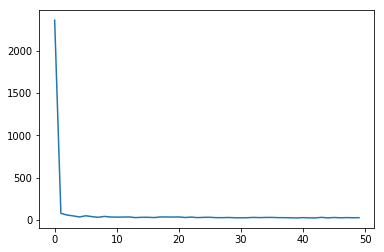

In [560]:
plt.plot(losses)

In [563]:
W1.value.shape

(13, 10)

In [565]:
W2.value.shape

(10, 1)

In [570]:
X_[1]

array([-0.41733926, -0.48772236, -0.59338101, -0.27259857, -0.74026221,
        0.19427445,  0.36716642,  0.55715988, -0.8678825 , -0.98732948,
       -0.30309415,  0.44105193, -0.49243937])

# linear_output = Linear(X,W1,b1)
# sigmoid_output = Sigmoid(linear_output)
# yhat = Linear(sigmoid_output, W2,b2)
# loss = MSE(y, yhat)

In [572]:
x1 = Input()

In [573]:
x1.value = X_[1]

In [575]:
y_of_x1 = Linear(Sigmoid(Linear(x1, W1,b1)), W2,b2)

In [579]:
y_of_x1?


In [580]:
def _sigmoid(x):
    return 1./ (1+np.exp(-1*x))

In [584]:
np.dot(_sigmoid(np.dot(X_[1],W1.value)+ b1.value), W2.value) + b2.value

array([24.87091105])

In [585]:
y_[1]

21.6